In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [64]:
# Load the dataset
df = pd.read_csv('train.csv', parse_dates=['date'], index_col='date')
df.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [65]:
# Filter data for a specific store and product family
store_number = 1  # Example store number
product_family = 'GROCERY I'  # Example product family

filtered_data = data[(data['store_nbr'] == store_number) & (data['family'] == product_family)]

In [66]:
# Aggregate sales by date
daily_sales = filtered_data['sales'].resample('D').sum()

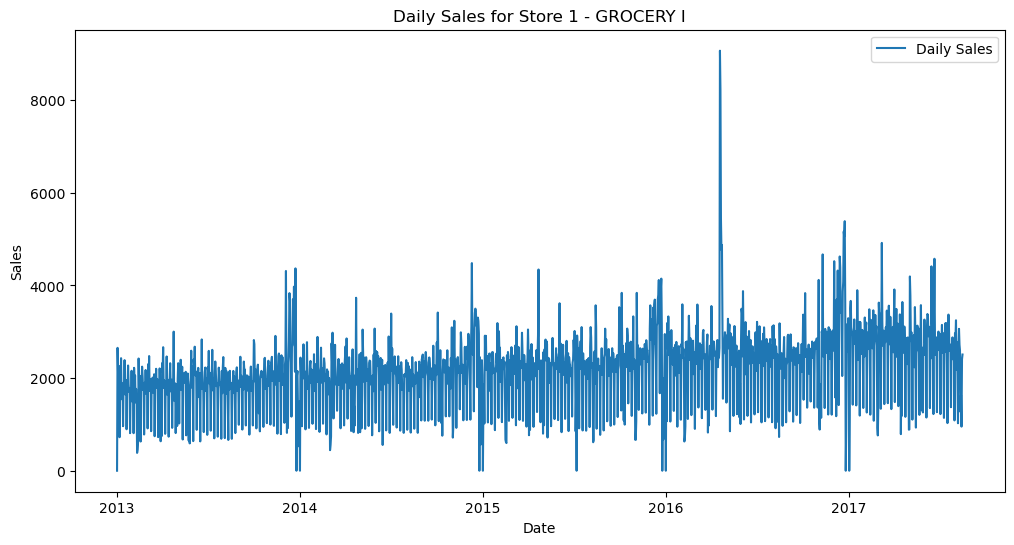

In [67]:
# Plot the daily sales
plt.figure(figsize=(12, 6))
plt.plot(daily_sales, label='Daily Sales')
plt.title(f'Daily Sales for Store {store_number} - {product_family}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [68]:
# Check for missing values
print(daily_sales.isnull().sum())

0


In [69]:
# Fill missing values if any (forward fill)
daily_sales = daily_sales.fillna(method='ffill')

# Perform Augmented Dickey-Fuller test for stationarity
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(daily_sales)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -4.304235319139254
p-value: 0.0004367701246459189


C:\Users\Jayant Vasa\AppData\Local\Temp\ipykernel_9628\2839535132.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_sales = daily_sales.fillna(method='ffill')


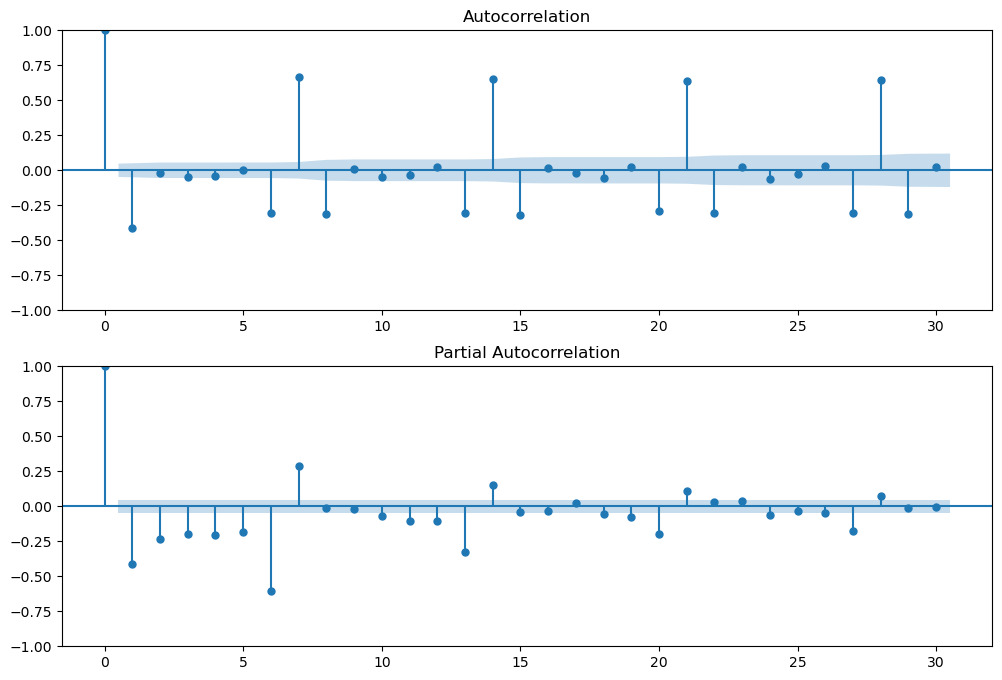

In [70]:
# Differencing to achieve stationarity if necessary
daily_sales_diff = daily_sales.diff().dropna()

# Plot ACF and PACF to determine parameters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, figsize=(12, 8))
plot_acf(daily_sales_diff, ax=ax[0], lags=30)
plot_pacf(daily_sales_diff, ax=ax[1], lags=30)
plt.show()

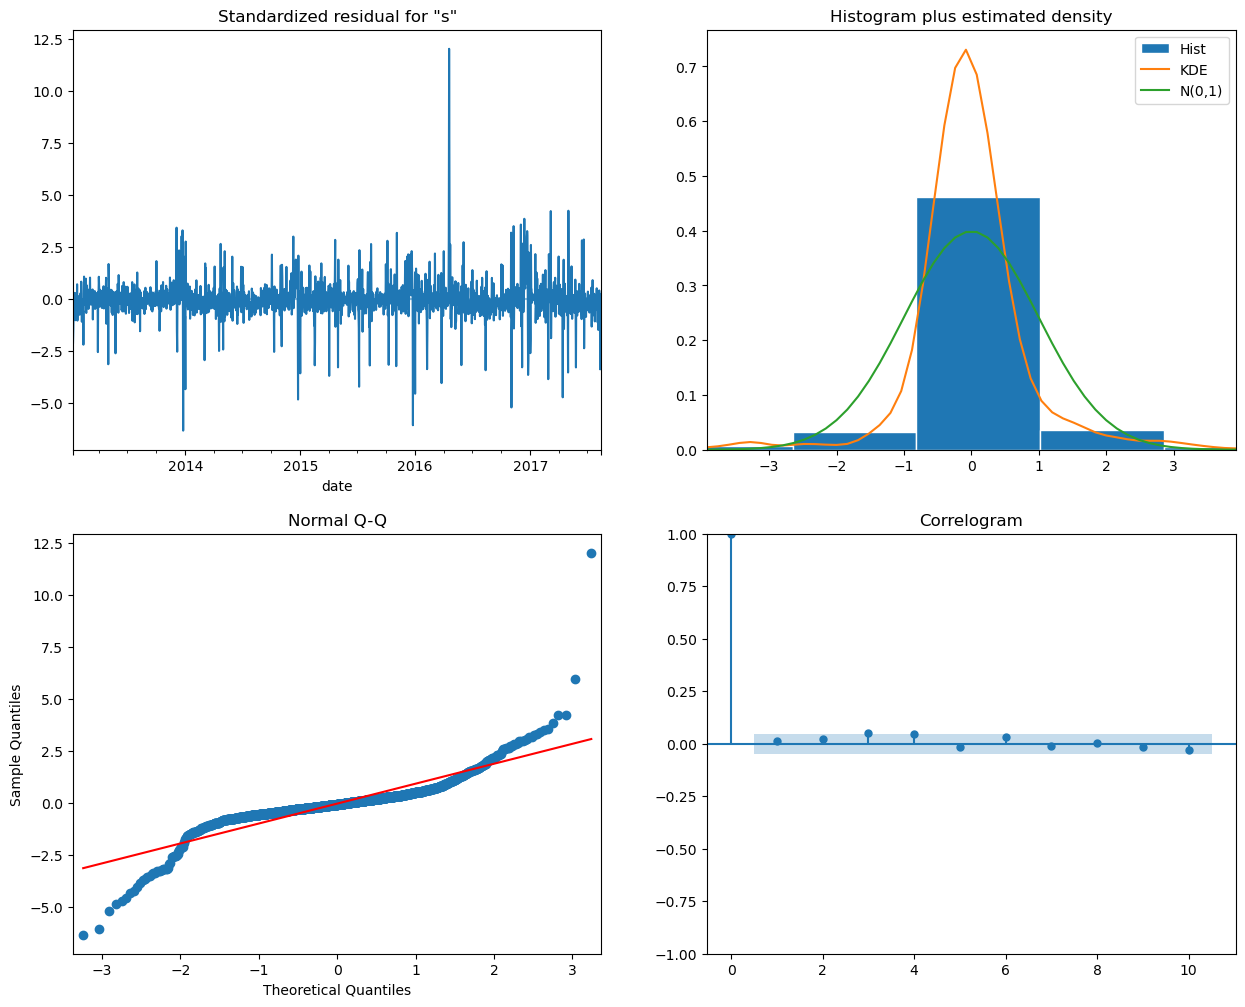

In [71]:
# Fit the SARIMA model
# Example parameters: (p,d,q) = (1,1,1), (P,D,Q,s) = (1,1,1,7)
model = SARIMAX(daily_sales, order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit()

# Model diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [72]:
# Forecasting
forecast_steps = 30  # Forecasting for the next 30 days
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

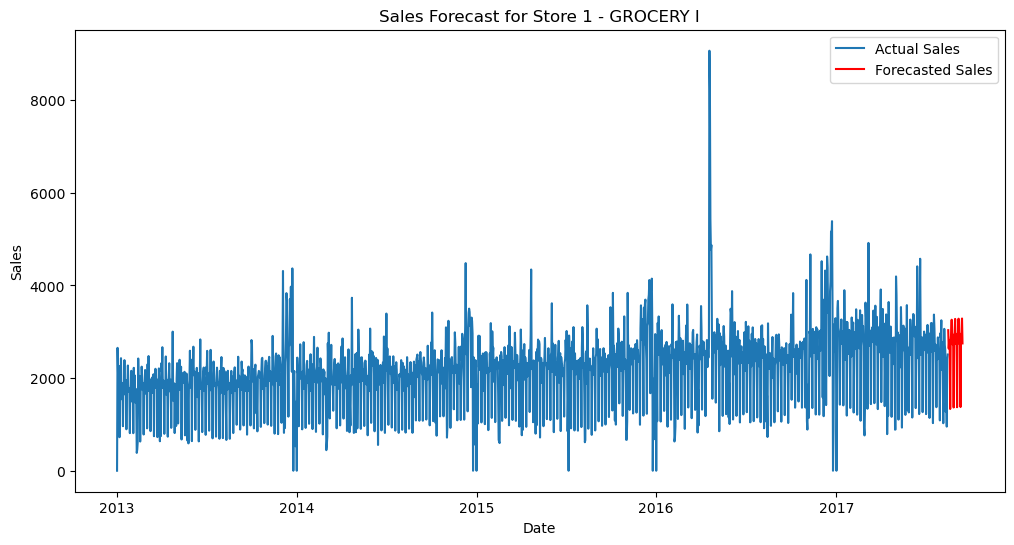

In [73]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_sales, label='Actual Sales')
plt.plot(forecast_series, label='Forecasted Sales', color='red')
plt.title(f'Sales Forecast for Store {store_number} - {product_family}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [74]:
# Model evaluation (using the last 30 days of actual data if available)
train_size = int(len(daily_sales) * 0.8)
train_data, test_data = daily_sales[:train_size], daily_sales[train_size:]
model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit()
forecast = results.get_forecast(steps=len(test_data))
forecast_series = pd.Series(forecast.predicted_mean.values, index=test_data.index)

In [89]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(test_data, forecast_series))
mae = mean_absolute_error(test_data, forecast_series)
mape = np.mean(np.abs((test_data - forecast_series) / test_data)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 599.0415116255376
MAE: 381.7061487273763
